In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mplfinance as mpf


In [2]:
def donchian_breakout(ohlcv, lookback=20):
    
    ohlcv['upper'] = upper = ohlcv['close'].rolling(lookback - 1).max().shift(1)
    ohlcv['lower'] = lower = ohlcv['close'].rolling(lookback - 1).min().shift(1)
    
    signal = pd.Series(np.full(len(ohlcv), np.nan), index=ohlcv.index)
    
    signal.loc[ohlcv['close'] > upper] = 1
    signal.loc[ohlcv['close'] < lower] = -1
    signal = signal.ffill()
    
    return signal

In [3]:
def optimize_donchian(ohlcv):

    best_pf = 0
    best_lookback = -1
    r = np.log(ohlcv['close']).diff().shift(-1)
    for lookback in range(10, 150):
        signal = donchian_breakout(ohlcv, lookback)
        sig_rets = signal * r
        sig_pf = sig_rets[sig_rets > 0].sum() / sig_rets[sig_rets < 0].abs().sum()

        if sig_pf > best_pf:
            best_pf = sig_pf
            best_lookback = lookback

    return best_lookback, best_pf

In [4]:
ohlcv = pd.read_csv("data/btc_usdt_2021_2025.csv")
signal = donchian_breakout(ohlcv, lookback=20)
best_lookback, best_pf = optimize_donchian(ohlcv)

print(f"After optimization, the lookback is {best_lookback}, and the best performance is {best_pf:.2f}")

After optimization, the lookback is 91, and the best performance is 1.14


In [5]:
def plot_donchain(ohlcv):
    
    df = ohlcv.copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df.set_index('timestamp', inplace = True)


    title_font = {'family': 'serif', 'weight': 'bold', 'size': 16}

    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(df.index, df['close'], label='closing price', alpha=0.7)
    ax.plot(df.index, df['close'].rolling(best_lookback - 1).max().shift(1), label = 'high band', linestyle = '--')
    ax.plot(df.index, df['close'].rolling(best_lookback - 1).min().shift(1), label = 'low band', linestyle = '-.')

    buy_signals = df[df['close'] > df['upper']]  
    sell_signals = df[df['close'] < df['lower']]

    ax.scatter(buy_signals.index, buy_signals['close'], marker='^', color='g', s=100, label='Buy Signal', alpha=1)
    ax.scatter(sell_signals.index, sell_signals['close'], marker='v', color='r', s=100, label='Sell Signal', alpha=1)

    ax.legend()
    ax.set_title("Donchain Strategy", fontdict=title_font)
    ax.set_xlabel("Date")
    ax.set_ylabel("Price")
    ax.grid(True, alpha=0.5)
    plt.show()

    fig, ax2 = plt.subplots(figsize=(12, 6))


    df['return'] = np.log(df['close']).diff().shift(-1) 
    df['donch_return'] = np.array(df.reset_index()['return'] * signal)
    df['cumulative_donch_return'] = df['donch_return'].cumsum()

    ax2.plot(df.index, df['cumulative_donch_return'], label='Cumulative Donchian Return', color='#2962FF')

    # Formatting
    ax2.set_title("Cumulative Returns of Donchian Breakout Strategy")
    ax2.set_xlabel("Date")
    ax2.set_ylabel("Cumulative Return")
    ax2.legend()
    ax2.grid(True, alpha=0.5)
    plt.show()


    
    DCU = df[['upper']]
    # DCM = df[['Middle']]
    DCL = df[['lower']]

    apds = [
        mpf.make_addplot(DCU,color='#FF6D00',panel=0,),
        # mpf.make_addplot(DCM,color='#FF6D00',panel=0,),
        mpf.make_addplot(DCL,color='#2962FF',panel=0,),
    ]

    mpf.plot(
        df,
        volume = True, 
        title="Candlestick with Rolling Upper and Lower Bound",
        type='candle',
        fill_between = dict(y1 = df['upper'].values, y2 = df['lower'].values, alpha = 0.1, color = '#2962FF'),  
        style = 'yahoo',
        addplot = apds, 
        figsize=(12, 6),
        warn_too_much_data=5000
        )

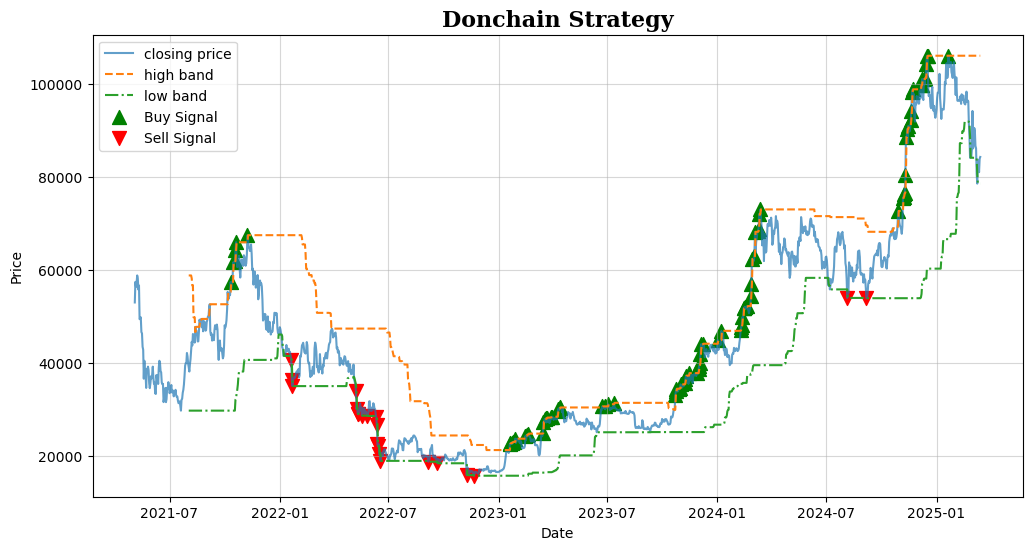

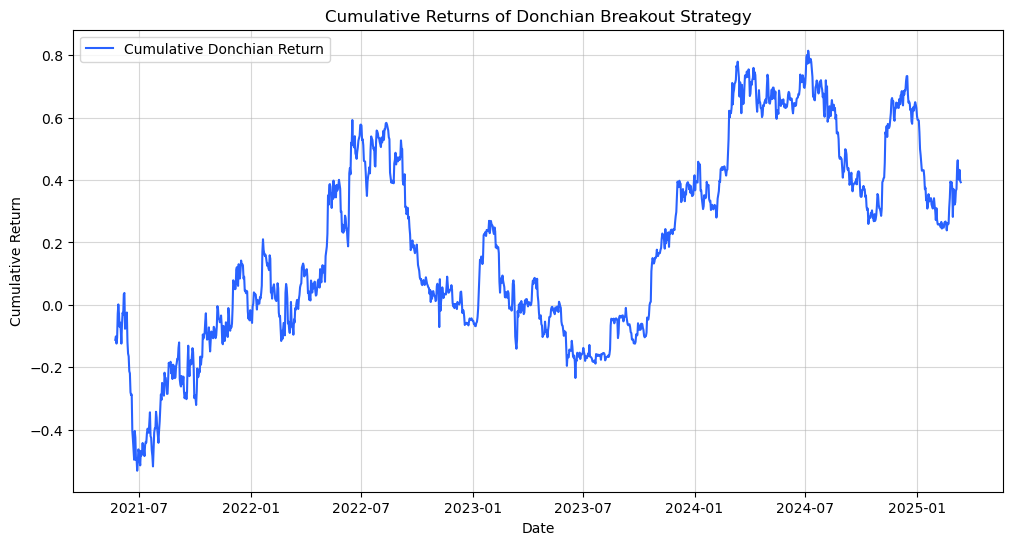

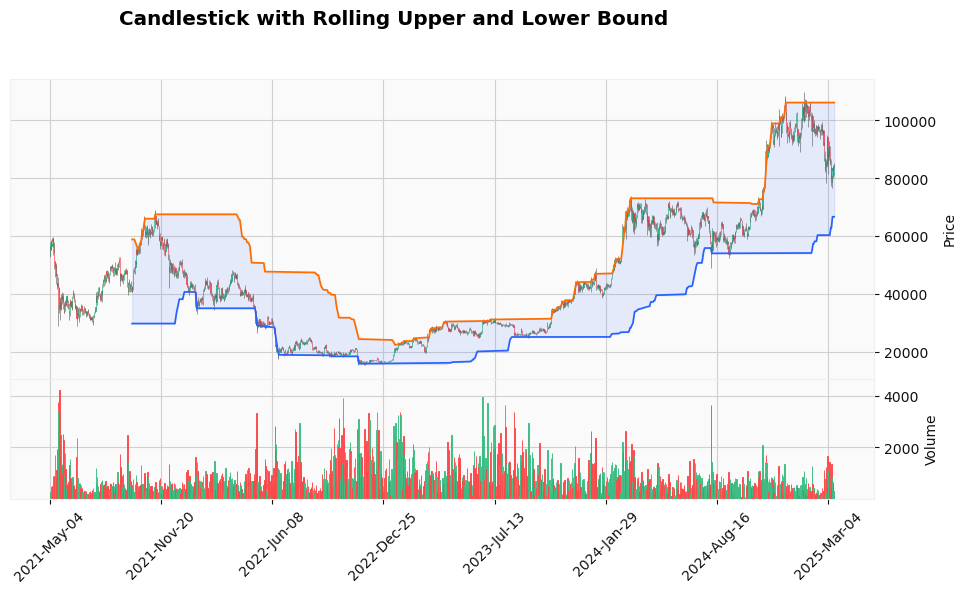

In [6]:
plot_donchain(ohlcv)